<div style="text-align: left;">
<table style="width:100%; background-color:transparent;">
  <tr style="background-color:transparent;">
    <td style="background-color:transparent;"><a href="http://www.datascience-paris-saclay.fr">
<img border="0" src="http://project.inria.fr/saclaycds/files/2017/02/logoUPSayPlusCDS_990.png" width="90%"> </td>
     <td style="background-color:transparent;"><a href="https://www.sidetrade.com/">

  </tr>
</table> 
</div>

<center><h1> Histopathologic Breast Cancer Detection </h1></center>


<center><h4> Authors: MADALI Nabil,Virgile Rennard,Mélanie Karlsen,Philippine Dolique
 </h4></center>

## Table of Contents

0. [Introduction](#Introduction)
1. [Data](#Data)
2. [Data exploration](#Data-exploration)
5. [Visualising the breast tissue](#Visualising-the-breast-tissue)
6.[Visualising the whole breast tissue](#Visualising-the-whole-breast-tissue)
7. [BASELINE MODEL](#BASELINE-MODEL)
8. [Visualising the prediction](#Visualising-the-prediction) 
9. [SUBMISSION ON RAMP ](#SUBMISSION-ON-RAMP)



#Introduction

Histopathology is concerned with the study of diseased tissue by microscopy. Tissue sections are stained with specific dyes to highlight structures of interest at the cellular and tissular level. Today, slides can be scanned and then analyzed manually on the screen; this is usually referred to as Digital Pathology.

Digital pathology has paved the way for the development and application of algorithms to automatically or semi-automatically analyze histopathology images.The potential benefits of automatic analysis include comprehensive measurements on the whole slide and the development of quantitative profiles informative about disease status and prognosis.

Today, Deep Learning is the method of choice to solve tasks related to histopathology data, such as segmentation, classification of individual cells or classification of tissue types and prediction of clinical variables from the tissue slide.However, due to thelarge size (typically in the range of 105x105) of tissue slides and their over whelming complexity and variability, automatic analysis of such slides remains a very challenging and highly competitive subject today.

Breast cancer (breast carcinoma) is a malignant transformation of epithelial tissue (usually glandular tissue). Fat (adipose) and fibrous tissue are both ‘connective’ tissues, which may also form into suspicious lesions on mammography.

However, breast cancer histology can almost always confirm the exact nature of a tumor or lesion.



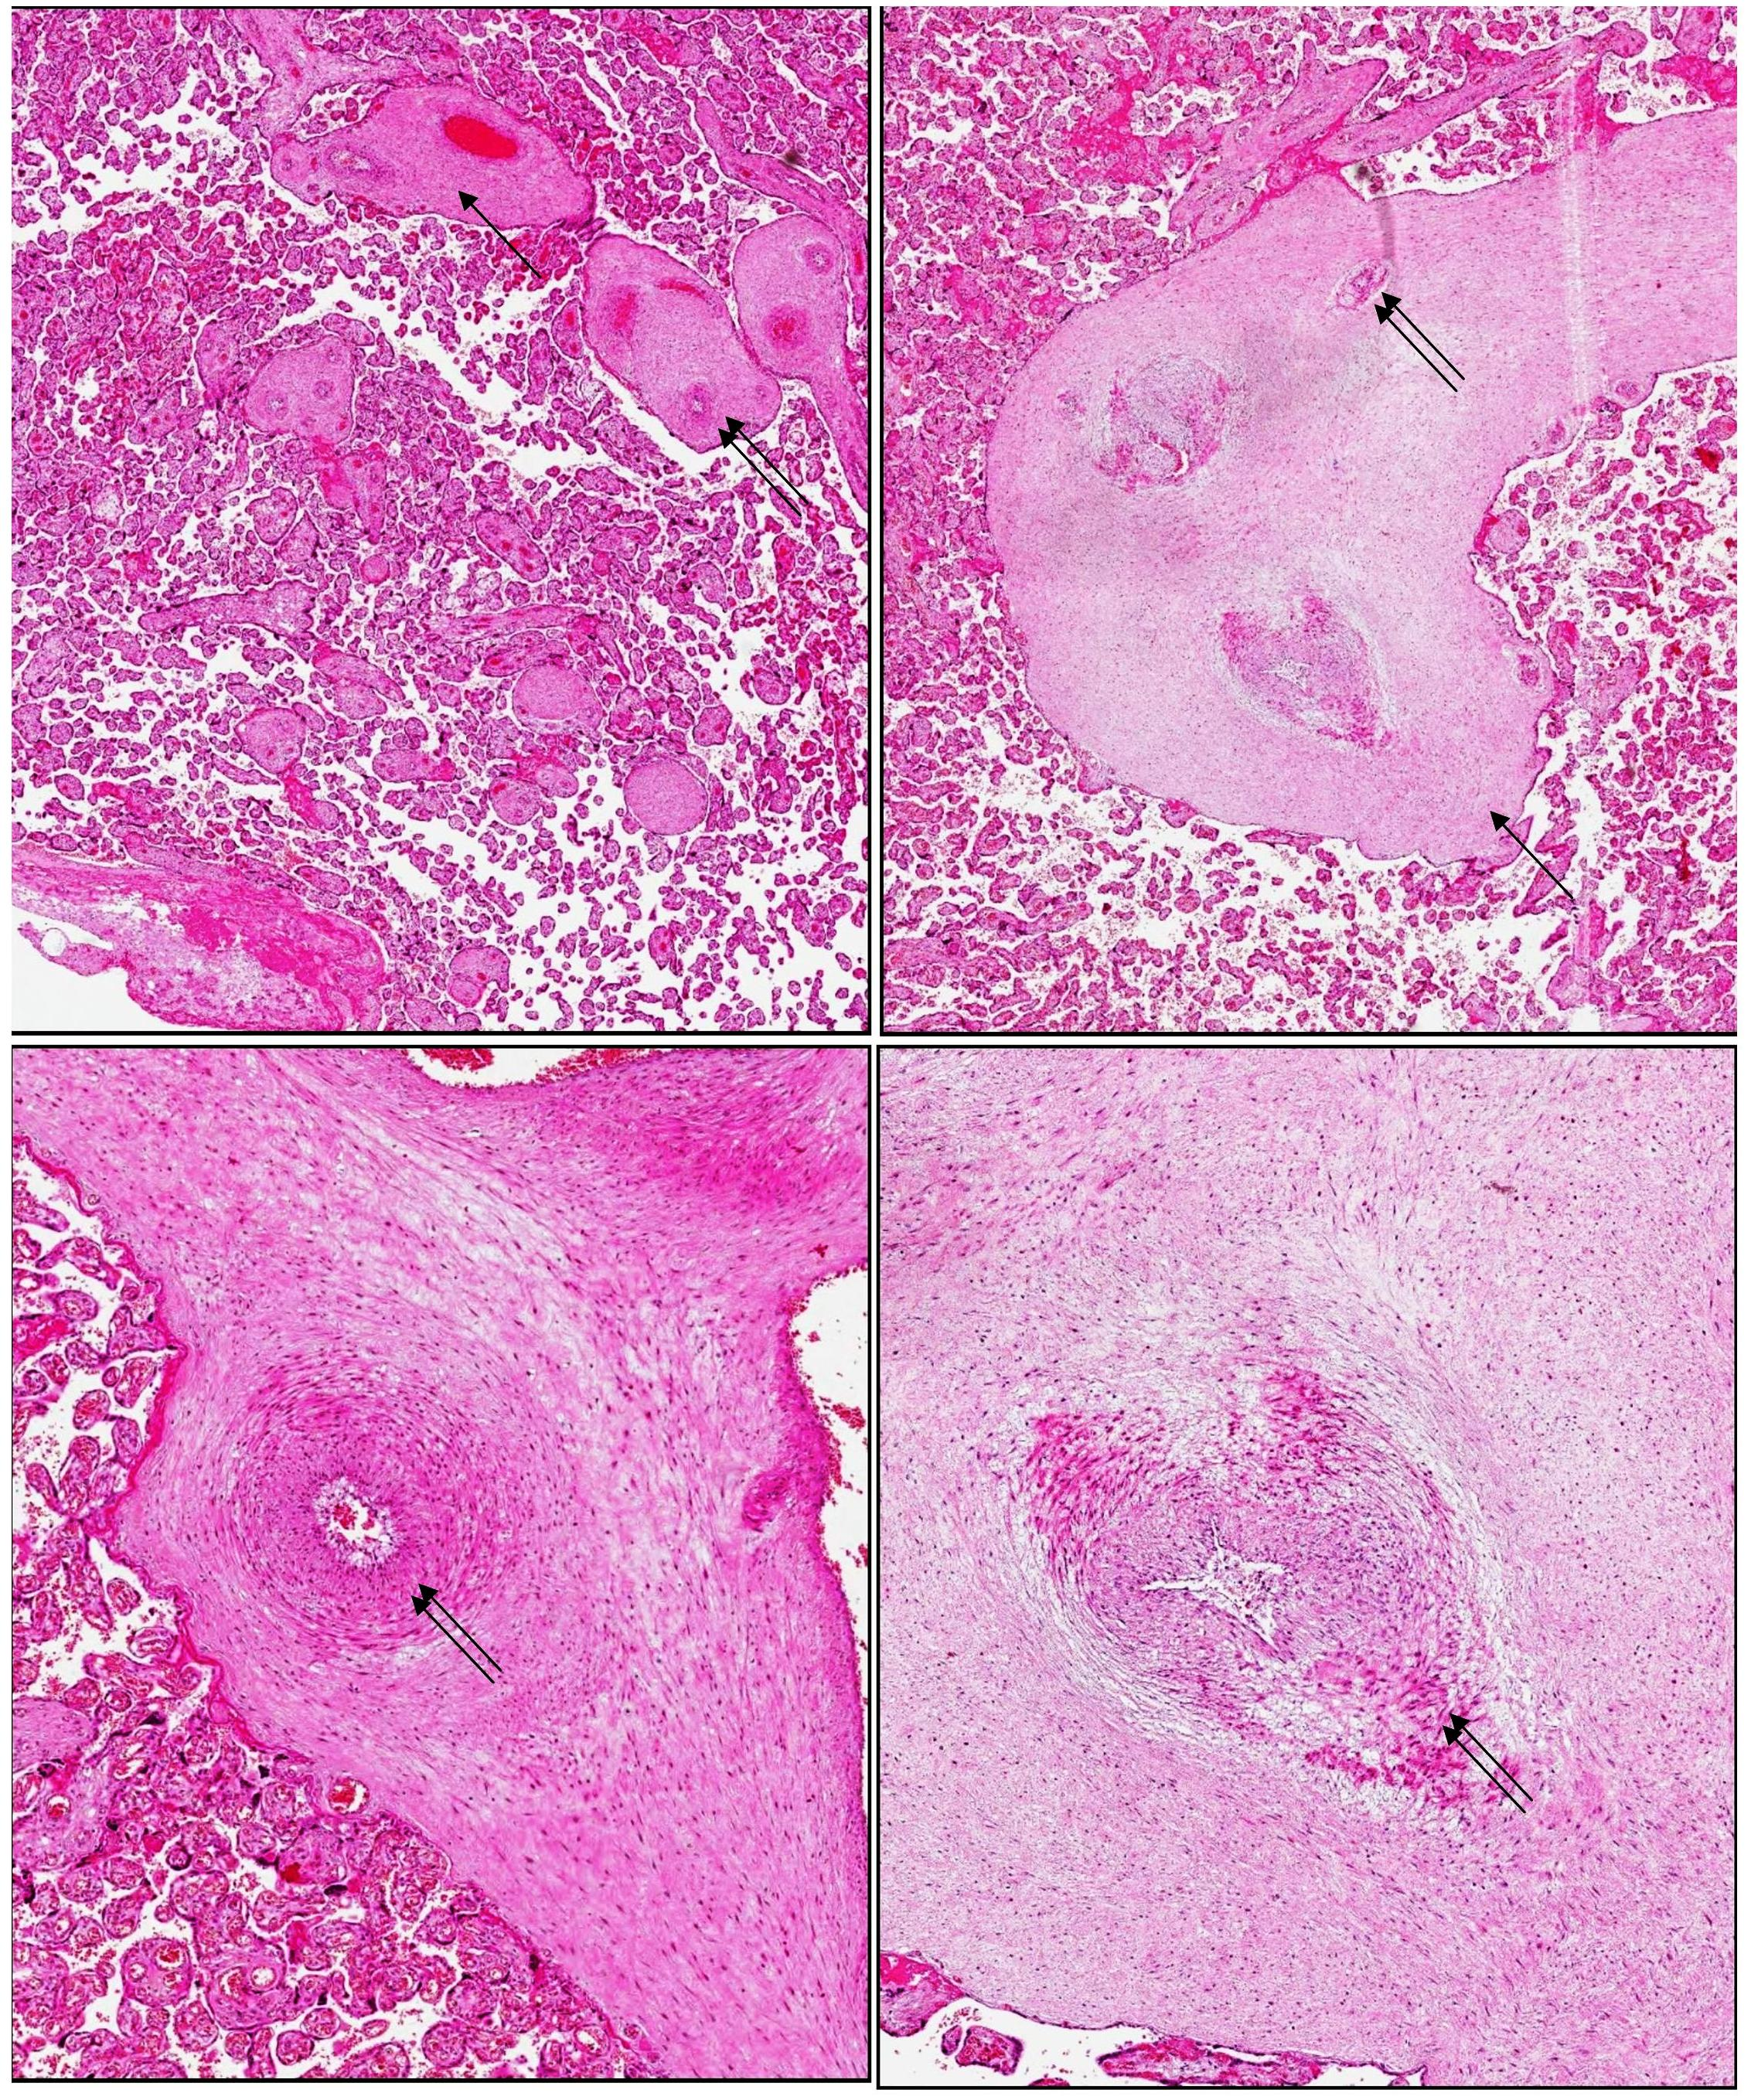

In [0]:
from IPython.display import Image
Image('image1.jpg', width=200, height=200)



Firstly, a suspicious breast lesion appears on mammogram or ultrasound.  Secondly a specialist will take a biopsy sample from the lesion and send it for a breast cancer histology evaluation by the pathologist.

There are different types of biopsy available and these obtain varying amounts of tissues.  The types of biopsy are:-

    fine needle biopsy
    core biopsy
    excisional biopsy

However, generally, one tries to remove as little tissue as possible while remaining confident that the sample is representative and taken from the right spot.

So, an initial biopsy sampling and analysis, is in some way, an extension of the breast cancer screening process and can confirm whether breast cancer is positive or negative. (Sometimes the lesion appears to be ‘at risk‘ for breast cancer, but is not yet malignant, resulting in a follow-up screening in a few months).


#Data
Breast Histopathology Images is a dataset from Kaggle (https://www.kaggle.com/paultimothymooney/breast-histopathology-images/kernels ).The dataset contains a large images show of tissue slices of patients with breast cancer.Our goal is  Given a patient and a patch of a tissue slice predict wheather it contains IDC or not.there is 3 possibilities : healthy tissue, IDC, another subtype of breast cancer

Prediction so far is done manually by pathologists and varies from expert to expert. The goal is to assist with an automatic detection of tumors (not expert dependent). 

The histopathological images are glass slide microscope images of lymph nodes that are stained with hematoxylin and eosin (H&E). This staining method is one of the most widely used in medical diagnosis and it produces blue, violet and red colors. Dark blue hematoxylin binds to negatively charged substances such as nucleic acids and pink eosin to positively charged substances like amino-acid side chains (most proteins). Typically nuclei are stained blue, whereas cytoplasm and extracellular parts in various shades of pink.




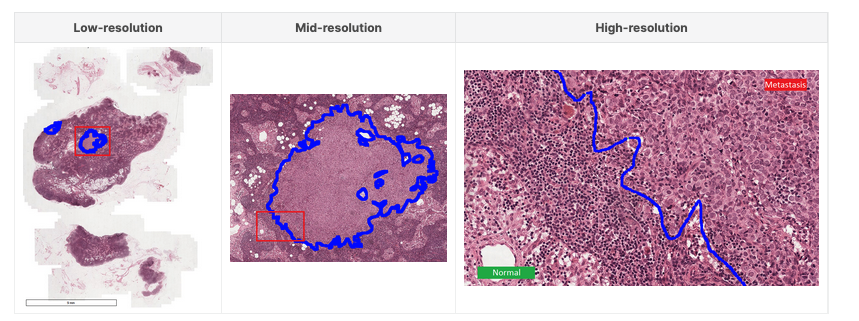

In [0]:
from IPython.display import Image
Image('image2.png', width=500, height=200)


Lymph nodes are small glands that filter the fluid in the lymphatic system and they are the first place a breast cancer is likely to spread. Histological assessment of lymph node metastases is part of determining the stage of breast cancer in TNM classification which is a globally recognized standard for classifying the extent of spread of cancer. The diagnostic procedure for pathologists is tedious and time-consuming as a large area of tissue has to be examined and small metastases can be easily missed.

# Import Data

In [0]:
!gdown https://drive.google.com/uc?id=1BK7RVm8BYajRkmsiZWTGJ7tWozC3bNU_

import zipfile
with zipfile.ZipFile("breast-histopathology-images.zip","r") as zip_ref:
    zip_ref.extractall("breast-histopathology-images")

Downloading...
From: https://drive.google.com/uc?id=1BK7RVm8BYajRkmsiZWTGJ7tWozC3bNU_
To: /content/Histopathologic-Breast-Cancer-Detection/breast-histopathology-images.zip
3.33GB [01:04, 52.0MB/s]


# Data-exploration

In [0]:
import pandas as pd
train= pd.read_csv('data/data.csv')
train.head()

patient_id                                               path  target
0        9254  breast-histopathology-images/IDC_regular_ps50_...       0
1       12867  breast-histopathology-images/IDC_regular_ps50_...       1
2       12749  breast-histopathology-images/IDC_regular_ps50_...       0
3       16533  breast-histopathology-images/IDC_regular_ps50_...       0
4        9261  breast-histopathology-images/IDC_regular_ps50_...       0

In [0]:
len(train)

55505

In each folder we should find several images or a further substructure of folders.


In [0]:
from os import listdir
files = listdir("breast-histopathology-images/")
print(len(files))

280


For each patient we have an individual subfolder that contains image patches.

In [0]:
base_path = "breast-histopathology-images/IDC_regular_ps50_idx5/"
folder = listdir(base_path)
len(folder)

279

Almost 280 patients. That's a small number compared to the expected number of patients one would like to analyse with our algorithm after deployment. Consequently overfitting to this specific patient distribution is very likely and we need to take care about the generalization performance of our model.

Our algorithm needs to decide whether an image patch contains IDC or not. Consequently not the whole patient tissue slice but the single patches have to be considered as input to our algorithm. How many of them do we have in total ?

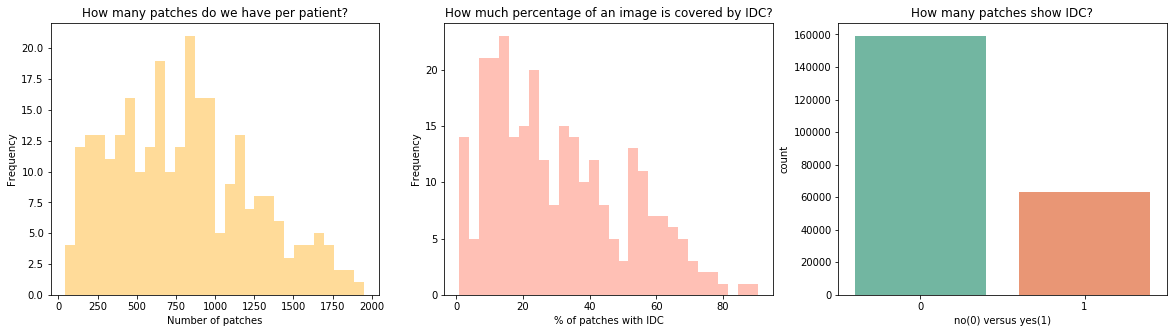

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
cancer_perc = train.groupby("patient_id").target.value_counts()/ train.groupby("patient_id").target.size()
cancer_perc = cancer_perc.unstack()

fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.distplot(train.groupby("patient_id").size(), ax=ax[0], color="Orange", kde=False, bins=30)
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency");
ax[0].set_title("How many patches do we have per patient?");
sns.distplot(cancer_perc.loc[:, 1]*100, ax=ax[1], color="Tomato", kde=False, bins=30)
ax[1].set_title("How much percentage of an image is covered by IDC?")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("% of patches with IDC");
sns.countplot(train.target, palette="Set2", ax=ax[2]);
ax[2].set_xlabel("no(0) versus yes(1)")
ax[2].set_title("How many patches show IDC?");



The number of image patches per patient varies a lot. This leads to the questions whether all images show the same resolution of tissue cells of if this varies between patients.

Some patients have more than 80 % patches that show IDC. Consequently the tissue is full of cancer or only a part of the breast was covered by the tissue slice that is focused on the IDC cancer. Does a tissue slice per patient cover the whole region of interest?

The classes of IDC versus no IDC are imbalanced. We have to check this again after setting up a validation strategy and find a strategy to deal with class weights .



#Visualising-the breast-tissue

We have to extract all coordinates of image patches that are stored in the image names. Then we can use the coordinates to reconstruct the whole breast tissue of a patient. This way we can also explore how diseased tissue looks like compared to healthy ones. To simplify this task let's write a method that takes a patient and outcomes a dataframe with coordinates and targets.

In [0]:
import numpy as np
def extract_coords(df):
    coord = df.path.str.rsplit("_", n=4, expand=True)
    coord = coord.drop([0, 1, 4], axis=1)
    coord = coord.rename({2: "x", 3: "y"}, axis=1)
    coord.loc[:, "x"] = coord.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    coord.loc[:, "y"] = coord.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    df.loc[:, "x"] = coord.x.values
    df.loc[:, "y"] = coord.y.values
    return df

def get_cancer_dataframe(patient_id, cancer_id):
    base_path="breast-histopathology-images"
    path = base_path + "/"+ str(patient_id) + "/" + cancer_id
    files = listdir(path)
    dataframe = pd.DataFrame(files, columns=["filename"])
    path_names = path + "/" + dataframe.filename.values
    dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
    dataframe.loc[:, "target"] = np.int(cancer_id)
    dataframe.loc[:, "path"] = path_names
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    dataframe.loc[:, "x"] = dataframe.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    dataframe.loc[:, "y"] = dataframe.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    return dataframe

def get_patient_dataframe(patient_id):
    df_0 = get_cancer_dataframe(patient_id, "0")
    df_1 = get_cancer_dataframe(patient_id, "1")
    patient_df = df_0.append(df_1)
    return patient_df
example = get_patient_dataframe(train.patient_id.values[0])
example.head()

x     y  target                                               path
0  2401  2101       0  breast-histopathology-images/9254/0/9254_idx5_...
1  1851  1501       0  breast-histopathology-images/9254/0/9254_idx5_...
2   751  1301       0  breast-histopathology-images/9254/0/9254_idx5_...
3  2651  1701       0  breast-histopathology-images/9254/0/9254_idx5_...
4  2401   501       0  breast-histopathology-images/9254/0/9254_idx5_...

In [0]:
example.describe()

x            y       target
count  1172.000000  1172.000000  1172.000000
mean   1830.820819  1194.984642     0.147611
std     950.174267   461.807879     0.354865
min      51.000000    51.000000     0.000000
25%     951.000000   851.000000     0.000000
50%    1751.000000  1201.000000     0.000000
75%    2651.000000  1551.000000     0.000000
max    3451.000000  2501.000000     1.000000

Before we will take a look at the whole tissue let's keep it a bit simpler by looking at the target structure in the x-y-space for a handful of patients:

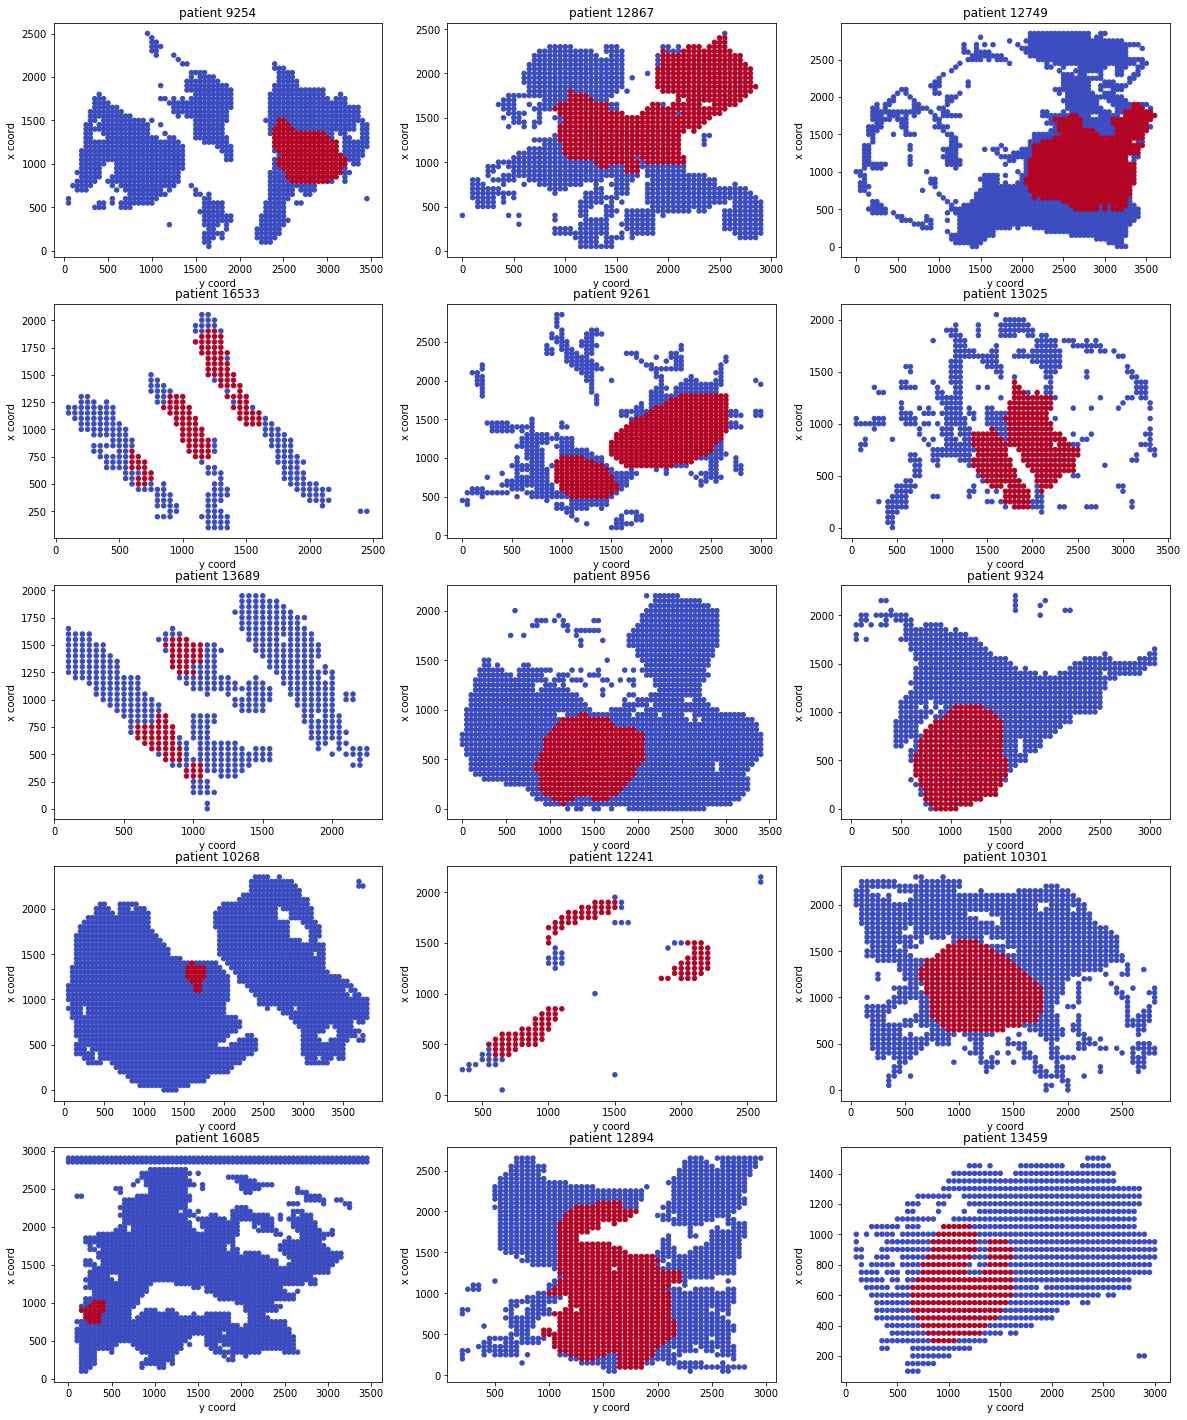

In [0]:
fig, ax = plt.subplots(5,3,figsize=(20, 25))

patient_ids = train.patient_id.unique()

for n in range(5):
    for m in range(3):
        patient_id = patient_ids[m + 3*n]
        example_df = get_patient_dataframe(patient_id)
        
        ax[n,m].scatter(example_df.x.values, example_df.y.values, c=example_df.target.values, cmap="coolwarm", s=20);
        ax[n,m].set_title("patient " + str(patient_id))
        ax[n,m].set_xlabel("y coord")
        ax[n,m].set_ylabel("x coord")

Sometimes we don't have the full tissue information. It seems that tissue patches have been discarded or lost during preparation. 
It seems to be related to this data this could also be part of the preprocessing.

# Visualising the whole breast tissue

Now it's time to go one step deeper with our EDA. Given the coordinates of image patches we could try to reconstruct the whole tissue image (not only the targets). 

In [0]:
def visualise_breast_tissue(patient_id, pred_df=None):
    example_df = get_patient_dataframe(patient_id)
    max_point = [example_df.y.max()-1, example_df.x.max()-1]
    grid = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    if pred_df is not None:
        pred_df = pred_df.loc[pred_df.patient_id==patient_id].copy()
        mask_proba = np.zeros(shape = (example_df.y.max(), example_df.x.max())).astype(np.uint8)
    
    broken_patches = []
    for n in range(len(example_df)):
        try:
            image = imread(example_df.path.values[n])
            
            target = example_df.target.values[n]
            
            x_coord = np.int(example_df.x.values[n])
            y_coord = np.int(example_df.y.values[n])
            x_start = x_coord - 1
            y_start = y_coord - 1
            x_end = x_start + 50
            y_end = y_start + 50

            grid[y_start:y_end, x_start:x_end] = image
            if target == 1:
                mask[y_start:y_end, x_start:x_end, 0] = 150
                mask[y_start:y_end, x_start:x_end, 1] = 150
                mask[y_start:y_end, x_start:x_end, 2] = 250
            if pred_df is not None:
                proba = pred_df[
                    (pred_df.x.astype(np.int)==x_coord) & (pred_df.y.astype(np.int)==y_coord)
                ].proba.values
                print(proba)
                mask_proba[y_start, x_start] = np.float(proba)
                print(mask_proba[y_start, x_start])

        except ValueError:
            broken_patches.append(example_df.path.values[n])
    
    if pred_df is not None:
        return grid, mask, broken_patches, mask_proba
    else:
        return grid, mask, broken_patches

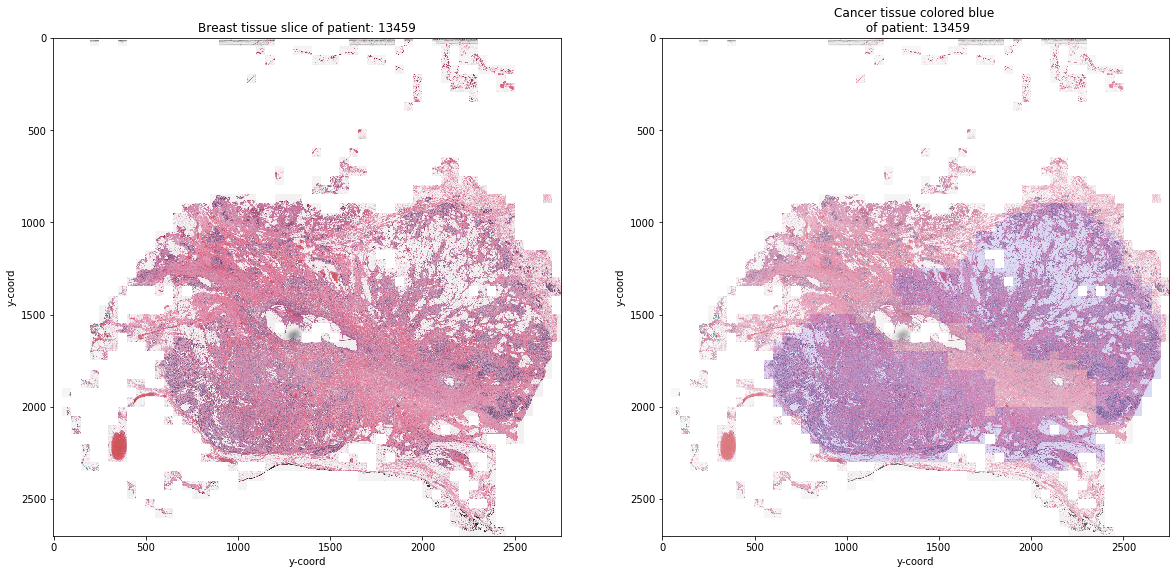

In [0]:
from skimage.io import imread
example = "13616"
grid, mask, broken_patches = visualise_breast_tissue(example)

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(grid, alpha=0.9)
ax[1].imshow(mask, alpha=0.8)
ax[1].imshow(grid, alpha=0.7)
ax[0].grid(False)
ax[1].grid(False)
for m in range(2):
    ax[m].set_xlabel("y-coord")
    ax[m].set_ylabel("y-coord")
ax[0].set_title("Breast tissue slice of patient: " + str(patient_id))
ax[1].set_title("Cancer tissue colored blue \n of patient: " + str(patient_id));

# BASELINE MODEL

When managing images, data with high level complexity, we thought of Deep Neural networks as models capable of extracting features in an automatic way.

for that, using keras package we developed a convolutional neural net with two hidden layer and a fully connected part that outputs a vector with dimension (num_classes,1)

In [0]:
import os
import cv2
import numpy as np
import pandas as pd
def loading_data(path, f_name):
    
    X_data=[]
    y_data=[]
    data_path = os.path.join(path, '{}.csv'.format(f_name))
    data = pd.read_csv(data_path)
    
    X_id = data['path'].values
    Y = data['target'].values
    
    for file in X_id:
       
        img = cv2.imread(file)
        img =cv2.resize(img , (50, 50))
        X_data.append(img)                    
    
    return (np.array(X_data)/ 255.,np.array(Y))

In [0]:
X_train, y_train = loading_data("data", 'train')


In [0]:
X_test, y_test = loading_data("data", 'test')

In [0]:
import keras
y_train = keras.utils.to_categorical(y_train,2)
y_test = keras.utils.to_categorical(y_test,2)

Using TensorFlow backend.


In [0]:
from __future__ import print_function
import numpy as np

import keras
from keras.datasets import mnist

from keras.models import Sequential 
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D 
from keras.optimizers import Adam, SGD, RMSprop

from keras.utils import np_utils 
from keras.callbacks import TensorBoard 
from keras import regularizers 
from time import time 

import matplotlib.pyplot as plt

In [0]:
np.random.seed(1671) # for reproducibility
# network and training

NB_EPOCH = 10 # number of epochs/episodes 
BATCH_SIZE = 32
VERBOSE = 1
VALIDATION_SPLIT=0.1 # how much TRAIN is reserved for VALIDATION


kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3
IMAGE_SIZE=50


In [0]:


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                 input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()

          
        








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 44, 44, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 20, 20, 64)        18496     


In [0]:
from keras.callbacks import TensorBoard  
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])
        
logdir = "logs/"
tensorboard_callback = TensorBoard(log_dir=logdir)

history = model.fit(X_train,y_train, batch_size=BATCH_SIZE,
                   epochs=NB_EPOCH,validation_split = VALIDATION_SPLIT,
          callbacks=[tensorboard_callback])




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 72509 samples, validate on 8057 samples







Epoch 1/10
72509/72509 [==============================] - 78s 1ms/step - loss: 0.5102 - acc: 0.7532 - val_loss: 0.5015 - val_acc: 0.7787

Epoch 2/10
72509/72509 [==============================] - 70s 971us/step - loss: 0.4398 - acc: 0.8054 - val_loss: 0.4550 - val_acc: 0.8005
Epoch 3/10
72509/72509 [==============================] - 71s 973us/step - loss: 0.4073 - acc: 0.8226 - val_loss: 0.5157 - val_acc: 0.7538
Epoch 4/10
72509/72509 [==============================] - 70s 969us/step - loss: 0.3953 - acc: 0.8302 - val_loss: 0.4215 - val_acc: 0.8140
Epoch 5/10
72509/72509 [==============================] - 70s 969us/step - loss: 0.3855 - acc: 0.8355 - val_loss: 0.4189 - val_acc: 0.8112
Epoch 6/10
72509/72509 [==============================] - 70s 966us/step - loss: 0.3767 - acc: 0.8401 - val_loss: 0.3958 - val_acc: 0.8291
Epoch 7/10
7

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


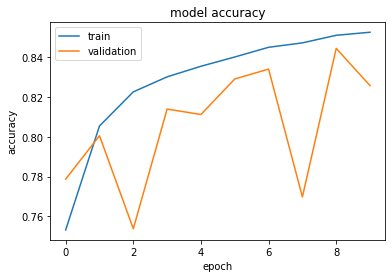

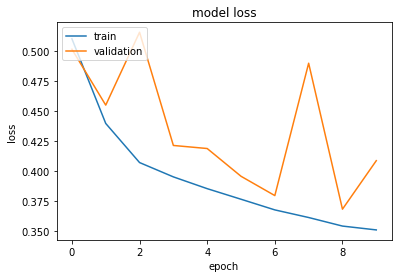

In [0]:
# tensorboard logs 
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [0]:
score = model.evaluate(X_test, y_test, verbose=VERBOSE,batch_size=BATCH_SIZE)
print("Test score:", score[0])
print('Test accuracy:', score[1])

20142/20142 [==============================] - 6s 294us/step
Test score: 0.4008241296761465
Test accuracy: 0.8297090656280801


# Visualising the prediction

In [0]:

train= pd.read_csv('data/train.csv')


patient_ids = train.patient_id.unique()
patient_id = patient_ids[0]
example_df = get_patient_dataframe(patient_id)
        


In [0]:
y_pred=[]
for row in example_df.values:
  img = cv2.imread(row[-1])
  img =cv2.resize(img , (50, 50))/255.
  y_pred.append(np.argmax(model.predict(img.reshape(1,50,50,3))))

Text(0, 0.5, 'x coord')

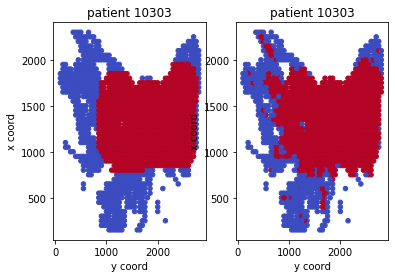

In [0]:
plt.subplot(1,2,1)
plt.scatter(example_df.x.values, example_df.y.values, c=example_df.target.values, cmap="coolwarm", s=20);
plt.title("patient " + str(patient_id))
plt.xlabel("y coord")
plt.ylabel("x coord")
plt.subplot(1,2,2)
plt.scatter(example_df.x.values, example_df.y.values, c=y_pred, cmap="coolwarm", s=20);
plt.title("patient " + str(patient_id))
plt.xlabel("y coord")
plt.ylabel("x coord")

## Reference
1. Thomas Walter "Master project: Deep Learning for Histopathology"
2. Kaggle "Histopathologic Cancer Detection" https://www.kaggle.com/c/histopathologic-cancer-detection
3. Joni Juvonen "A complete ML pipeline (Fast.ai)" https://www.kaggle.com/qitvision/a-complete-ml-pipeline-fast-ai
4. CVxTz "CNN - How to use 160,000 images without crashing" https://www.kaggle.com/vbookshelf/cnn-how-to-use-160-000-images-without-crashing
5. Rohit Gupta "fastaiv1-with-densenet121-and-focal-loss" https://www.kaggle.com/rohitgr/fastaiv1-with-densenet121-and-focal-loss
6. Kaggle "Breast Histopathology Images
" https://www.kaggle.com/paultimothymooney/breast-histopathology-images
7. Allunia ,Andy "BreastCancer" ,https://www.kaggle.com/allunia/breastcancer




#SUBMISSION ON RAMP 

## Submission files 
After you find a good model, you have to write an BatchClassifier class on the goal to do a submission.
Here, is a example of BatchClassifier class implementing the model explain above.

In [0]:
%%file submissions/starting_kit/batch_classifier.py
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense,Reshape
from keras.layers import Flatten
from keras.optimizers import SGD
from rampwf.workflows.image_classifier import get_nb_minibatches
from keras.layers import Conv2D, MaxPooling2D

import numpy as np


from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD,Adam
from keras.preprocessing.image import ImageDataGenerator
import cv2


class BatchClassifier(object):
    def __init__(self):
        self.model = self._build_model()

    def fit(self, gen_builder):
        batch_size = 128
        gen_train, gen_valid, nb_train, nb_valid =\
            gen_builder.get_train_valid_generators(
                batch_size=batch_size, valid_ratio=0.1)
        self.model.fit_generator(
            gen_train,
            # Total number of steps (batches of samples) to yield from
            # generator before declaring one epoch finished and starting the
            # next epoch. It should typically be equal to the number of unique
            # samples of your dataset divided by the batch size.
            steps_per_epoch=get_nb_minibatches(nb_train, batch_size),
            epochs=3,
            # In parallel to training, a CPU process loads and preprocesses
            # data from disk and put it into a queue in the form of
            # mini-batches of size `batch_size`.`max_queue_size` controls the
            # maximum size of that queue. The size of the queue should be big
            # enough so that the training process (GPU) never
            # waits for data (the queue should be never be empty).
            # The CPU process loads chunks of 1024 images each time, and
            # 1024/batch_size mini-batches from that chunk are put into the
            # queue. Assuming training the model on those 1024/batch_size
            # mini-batches is slower than loading a single chunk of 1024
            # images, a good lower bound for `max_queue_size` would be
            # (1024/batch_size). if `batch_size` is 16, you can put
            # `max_queue_size` to 64.
            max_queue_size=64,
            # WARNING : It is obligatory to set `workers` to 1.
            # This in principle controls the number of workers used
            # by keras to load mini-batches from disk to memory in parallel
            # to GPU training. But I don't like the way it works and their
            # code is not very commented/used, so I dont trust it that much
            # (we might have surprises).
            # The way it works in keras is by launching in parallel `workers`
            # threads or processes which will all use a copy of the generator
            # passed to `fit_generator`. So if nothing is done and `workers`
            # is set to some number > 1, the neural net will be trained with
            # repetitions of the same data, because the workers are independent
            # and they got through the same generator.
            # Hence it is necessary to introduce a shared lock between the the
            # processes so that they load different data, this can become a bit
            # complicated, so I choose to rather load exactly one chunk at a
            # time using 1 worker (so `workers` have to be equal to 1), but
            # do this single chunk loading in parallel with joblib.
            workers=1,
            use_multiprocessing=True,
            validation_data=gen_valid,
            validation_steps=get_nb_minibatches(nb_valid, batch_size),
            verbose=1)

    def predict_proba(self, X):
        return self.model.predict(X)

    def _build_model(self):
        kernel_size = (3,3)
        pool_size= (2,2)
        first_filters = 32
        second_filters = 64
        third_filters = 128

        dropout_conv = 0.3
        dropout_dense = 0.3
        IMAGE_SIZE=50

        model = Sequential()
        model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                        input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
        model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
        model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
        model.add(MaxPooling2D(pool_size = pool_size)) 
        model.add(Dropout(dropout_conv))

        model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
        model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
        model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
        model.add(MaxPooling2D(pool_size = pool_size))
        model.add(Dropout(dropout_conv))

        model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
        model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
        model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
        model.add(MaxPooling2D(pool_size = pool_size))
        model.add(Dropout(dropout_conv))

        model.add(Flatten())
        model.add(Dense(256, activation = "relu"))
        model.add(Dropout(dropout_dense))
        model.add(Dense(2, activation = "softmax"))
       
        model.compile(Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
        
        
        return model

Writing submissions/starting_kit/batch_classifier.py


In [0]:
%%file submissions/starting_kit/image_preprocessor.py
import cv2
def transform(x):   
        x = x / 255.
        x_resize = cv2.resize(x, (50,50))
        return x_resize

Writing submissions/starting_kit/image_preprocessor.py


## Local testing before submitted to RAMP  

You have to test your submissions files before doing your submissions. In that goal, use ramp_test_submission command. Notice that this unit test run in the folder [`submissions/starting_kit`](/tree/submissions/starting_kit).
Before running the test, make sure you have done the following tasks:

- install ramp-workflow
- write the python file BatchClassifier.py and put it in the following folder [`submissions/starting_kit`].
- download the data 

You have two possibilities to test your submissions, a complete test (train and test the model with cross validtion like the server will do or a quick test (just to make sure the submissions code are working). If the test run, print train and test erros on each fold of the cross validation you can then submit to ramp.

Execute the following cell to do a quick test:

In [0]:
!pip install git+https://github.com/paris-saclay-cds/ramp-workflow

  Cloning https://github.com/paris-saclay-cds/ramp-workflow to /tmp/pip-req-build-gl4v_432
  Running command git clone -q https://github.com/paris-saclay-cds/ramp-workflow /tmp/pip-req-build-gl4v_432
  Created wheel for ramp-workflow: filename=ramp_workflow-0.2.0+58.gc1b4273-cp36-none-any.whl size=2957723 sha256=6f64e183f082bd52e376d0a31393e9c44c1087662f3e5d4b59669a8ccf1da75e
  Stored in directory: /tmp/pip-ephem-wheel-cache-_h_agvys/wheels/35/a2/c3/7969a73ddfefc0dcad3709cb7a81f52fb90348df9bb9b8c455
Successfully built ramp-workflow


In [0]:
!ramp_test_submission --quick-test

Testing Breast Cancer classification
Reading train and test files from ./data ...
Reading cv ...
Training submissions/starting_kit ...
CV fold 0
Using TensorFlow backend.





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/1


2020-01-04 15:18:46.482839: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX512F
2020-01-04 15:18:46.504378: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2000170000 Hz
2020-01-04 15:18:46.504832: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1adad80 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-01-04 15:18:46.504873: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default V